# Import library

In [1]:
import os
import sys
import traci
from sumolib import checkBinary 
import pandas as pd
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

# Set the variable
Logic 
1. Number of vehicles in each lane - halting vehicle + non-halting
2. Number of halting vehicles 
3. Propotion of vehicles and number of lane

Index phases from Traffic light logic
- North -> 0 (-E2, 66)
- South -> 2 (-E0, 71)
- West -> 4 (-E1, 45)
- East -> 6 (-E3, 50)

In [2]:
useGui = False
logic = 2
yellowTime = 5
percentProportion = 0.5
maxPercentProportion = 0.5
vphs = [1000, 2000, 3000, 3500, 4000, 4500,5000]
#vphs = [3000, 3500, 4000, 4500, 5000]
vphs = [5000]
num_lane = [3, 4, 2, 2]
edge_name = {0: '-E2', 1: '-E0', 2: '-E1', 3: '-E3'}
standard_time = [66, 71, 45, 50] # north, south, west, east
direction = ['N', 'S', 'W', 'E']

In [3]:
if logic == 1:
    name = 'num_veh'
    graph = 'number of vehicles'
elif logic == 2:
    name = 'num_halting'
    graph = 'number of halting vehicles'
elif logic == 3:
    name = 'proportion'
    graph = 'proportion'

# Function 

In [4]:
def getEdgeHaltingVehicles(edge):
  return traci.edge.getLastStepHaltingNumber(edge)

def getEdgeTotalVehicles(edge):
  return traci.edge.getLastStepVehicleNumber(edge)

def getEdgeWaitingTime(edge):
  return traci.edge.getWaitingTime(edge)

def getEdgeAccumulativeWaitingTime(edge):
  # get all vehicles ID and then get accumulative waiting time for each car ID
  return sum(traci.vehicle.getAccumulatedWaitingTime(vehicle) for vehicle in traci.edge.getLastStepVehicleIDs(edge))
 
def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

# Experiment

In [5]:
simulation_data = pd.DataFrame(columns=['Vehicles Per Hour', 'Accumulated Time', 'Clear Time'])
total_cars_data = {}
traffic_control = {}

for i in vphs:
  net_file = './saint_paul/junction.net.xml'
  route_path = f'./saint_paul/1.0hour/trips/{i}.rou.xml'
  #route_path = './saint_paul/1.0hour/trips/real_world.rou.xml'

  if(useGui): sumoBinary = checkBinary('sumo-gui')
  else: sumoBinary = checkBinary('sumo')
  sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

  traci.start(sumoCmd)

  trafficLightId = traci.trafficlight.getIDList()[0]
  allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
  allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases
  
  switchTime = 0
  currentPhase = 0
  yellowPhase = False
  latest_time = [0, 0, 0, 0]

  waiting_time = {}
  halting_cars = []
  all_car_in_sim = []
  proportion_lane = [1, 1, 1, 1]
  time = []
  traffic_time = []

  while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()
    currentTime = traci.simulation.getTime()
    #find the next phases to open (yellow and green)
    if currentTime >= switchTime:
      # Swicth to green phase
      if yellowPhase:
        currentPhase = (currentPhase + 1) % 4
        if logic == 1:
          totalVehicles = getEdgeTotalVehicles(edge_name[currentPhase])
          switchTime += int(min(max(15, totalVehicles / (0.45 * num_lane[currentPhase])), 120))
        elif logic == 2:
          totalHaltingVehicles = getEdgeHaltingVehicles(edge_name[currentPhase])
          green_time = int(min(max(15, totalHaltingVehicles / (0.45 * num_lane[currentPhase])), 120))
          switchTime += green_time

          traffic_time.append([direction[currentPhase], green_time])
        elif logic == 3:
          realCars = getEdgeHaltingVehicles(edge_name[currentPhase])
          expectedCars = num_lane[currentPhase] * 50
          current_proportion = realCars/expectedCars
          
          proportion_lane[currentPhase] = current_proportion
          avg_proportion = sum(proportion_lane)/4 if sum(proportion_lane) != 0 else 1

          current_based = int(min(current_proportion*percentProportion*standard_time[currentPhase], maxPercentProportion*standard_time[currentPhase]))
          current_based = current_based if realCars > expectedCars else -1*current_based
          overall_based = int(min(current_proportion/avg_proportion*percentProportion*standard_time[currentPhase], maxPercentProportion*standard_time[currentPhase]))
          overall_based = overall_based if current_proportion > avg_proportion else -1*current_based

          green_time = standard_time[currentPhase] + current_based + overall_based
          switchTime += green_time
          traffic_time.append([direction[currentPhase], green_time])
        
        yellowPhase = False
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2].state)
      # Swicth to yellow phase before switch to green phase
      else:
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2 + 1].state)
        switchTime += yellowTime
        yellowPhase = True

    vehicles = traci.vehicle.getIDList()

    all_car_in_sim.append(len(vehicles))
    halting_cars.append(sum(getEdgeHaltingVehicles(edge) for edge in edge_name.values()))
    
    for vehicle in vehicles:
      vehicle_waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle)
      if(vehicle not in waiting_time):
        waiting_time[vehicle] = vehicle_waiting_time
      else:
        waiting_time[vehicle] = max(vehicle_waiting_time, waiting_time[vehicle])
    total_clear_time = currentTime

  total_waiting_time = sum(waiting_time[vehicle] for vehicle in waiting_time)
  total_cars_data[i] = {'All Cars': all_car_in_sim, 'Halting Cars': halting_cars}
  traffic_control[i] = pd.DataFrame(traffic_time, columns=['Direction', 'Time'])
  simulation_data.loc[len(simulation_data.index)] = [i, total_waiting_time, total_clear_time]  
  print('\n', i, total_waiting_time, total_clear_time)
    
  traci.close()

 Retrying in 1 seconds



 5000 2900416.0 6981.0
Step #6981.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 5009 ACT 0 BUF 0)                 


# Save Results

In [ ]:
result_path = './saint_paul/1.0hour/adaptive.csv'
result = pd.read_csv(result_path)

if logic == 2:
    result[f'adaptive_logic_{name}_waiting'] = simulation_data['Accumulated Time']
    result[f'adaptive_logic_{name}_clear'] = simulation_data['Clear Time']
elif logic == 3:
    result[f'adaptive_logic_{name}_{percentProportion}_waiting'] = simulation_data['Accumulated Time']
    result[f'adaptive_logic_{name}_{percentProportion}_clear'] = simulation_data['Clear Time']

result.to_csv(f'{result_path}', index=False)

# Plot graph

### Plot experiment

In [ ]:
df = pd.read_csv('./saint_paul/1.0hour/adaptive.csv')

plt.plot(simulation_data['Vehicles Per Hour'], df['waiting_fixed'] /simulation_data['Vehicles Per Hour']/60, label = "Fixed Phase")
plt.plot(simulation_data['Vehicles Per Hour'], simulation_data['Accumulated Time']/simulation_data['Vehicles Per Hour']/60, label = f"Adaptive Traffic Control Logic based on {graph}")
plt.xticks(df['Vehicles Per Hour'])
plt.xlabel('Number of vehicle')
plt.ylabel('Minutes')
plt.title('Average Waiting Time Per Car')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(df['Vehicles Per Hour'], df['clear_fixed']/60, label = "Fixed Phase")
plt.plot(df['Vehicles Per Hour'], df['adaptive_logic_num_halting_clear']/60, label = f"Adaptive Control based on Number of Halting vehicles")
plt.xticks(simulation_data['Vehicles Per Hour'])
plt.xlabel('Number of vehicle')
plt.ylabel('Minutes')
plt.title('Clear Time of Simulation')
plt.grid()
plt.legend()
plt.show()

In [ ]:
print(sum(df['waiting_fixed']/df['Vehicles Per Hour']/60)/7, sum(df['diff-waiting-time_4000_waiting']/df['Vehicles Per Hour']/60)/7)
print(sum(df['waiting_fixed']/df['Vehicles Per Hour']/60)/7, sum(df['adaptive_logic_proportion_0.2_waiting']/df['Vehicles Per Hour']/60)/7)
print(sum(df['waiting_fixed']/df['Vehicles Per Hour']/60)/7, sum(df['adaptive_logic_proportion_0.5_waiting']/df['Vehicles Per Hour']/60)/7)

In [ ]:

print(sum(df['clear_fixed']/60)/7, sum(df['diff-waiting-time_4000_clear']/60)/7)
print(sum(df['clear_fixed']/60)/7, sum(df['adaptive_logic_proportion_0.2_clear']/60)/7)
print(sum(df['clear_fixed']/60)/7, sum(df['adaptive_logic_proportion_0.5_clear']/60)/7)

In [ ]:
df = pd.read_csv('./saint_paul/1.0hour/adaptive.csv')

plt.plot(df['Vehicles Per Hour'], df['clear_fixed']/60, label = "Fixed Phase")
plt.plot(df['Vehicles Per Hour'], df['']/60, label = f"Adaptive Control based on 0.1 proportion number")
plt.plot(df['Vehicles Per Hour'], df['adaptive_logic_proportion_0.2_waiting']/df['Vehicles Per Hour']/60, label = f"Adaptive Control based on 0.2 proportion number")
plt.plot(df['Vehicles Per Hour'], df['adaptive_logic_proportion_0.5_waiting']/df['Vehicles Per Hour']/60, label = f"Adaptive Control based on 0.5 proportion number")
#plt.plot(df['Vehicles Per Hour'], df['adaptive_logic_proportion_0.6_waiting']/df['Vehicles Per Hour']/60, label = f"Adaptive Traffic Control Logic based on 0.6 proportion number")
plt.xticks(df['Vehicles Per Hour'])
plt.xlabel('Number of vehicle')
plt.ylabel('Minutes')
plt.title('Average Waiting Time Per Car')
plt.grid()
plt.legend()
plt.show()

In [ ]:
sum(df['waiting_fixed']/df['Vehicles Per Hour']/60)/5, sum(simulation_data['Accumulated Time']/df['Vehicles Per Hour']/60)/5

In [ ]:
simulation_data['Accumulated Time'], df['Vehicles Per Hour']

In [ ]:
sum(df['clear_fixed']/60)/5, sum(simulation_data['Clear Time']/60)/5

In [ ]:
plt.plot(df['Vehicles Per Hour'], df['clear_fixed']/60, label = "Fixed Phase")
plt.plot(df['Vehicles Per Hour'], df['diff-waiting-time_4000_clear']/60, label = "DQN by waiting time")
plt.plot(df['Vehicles Per Hour'], df['queue_4000_clear']/60, label = "DQN by queue")

plt.xticks(df['Vehicles Per Hour'])
plt.xlabel('Number of vehicle')
plt.ylabel('Minutes')
plt.title('Clear Time of Simulation')
plt.grid()
plt.legend()
plt.show()

### Number of cars

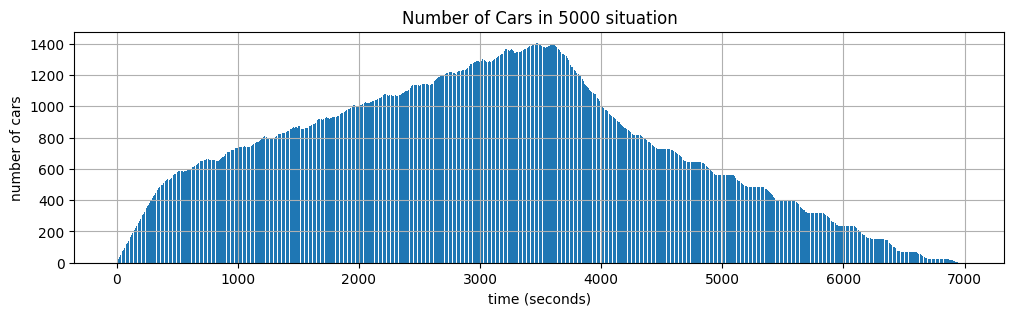

In [6]:
num = 5000
clearTime = int(list(simulation_data.loc[simulation_data['Vehicles Per Hour']==num, 'Clear Time'])[0])

time = [t for t in range(clearTime)]
number_of_cars = total_cars_data[num]['All Cars']

plt.subplots(figsize=(12, 3))
plt.bar(time, number_of_cars)
plt.title(f'Number of Cars in {num} situation')
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()

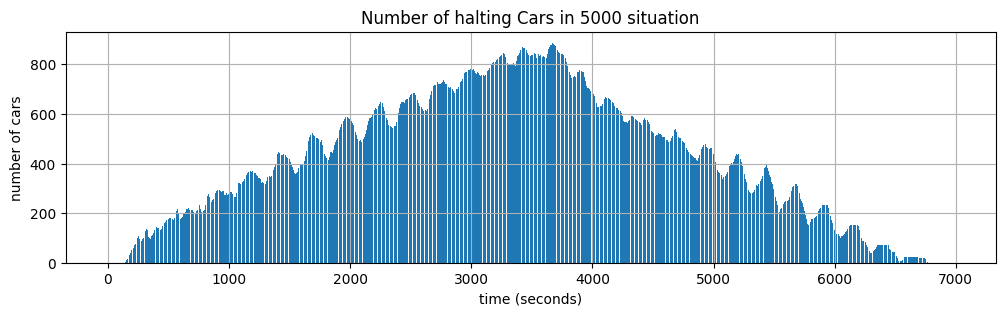

In [7]:
clearTime = int(list(simulation_data.loc[simulation_data['Vehicles Per Hour']==num, 'Clear Time'])[0])

time = [t for t in range(clearTime)]
number_of_cars = total_cars_data[num]['Halting Cars']

plt.subplots(figsize=(12, 3))
plt.bar(time, number_of_cars)
plt.title(f'Number of halting Cars in {num} situation')
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()

### Green Time

In [ ]:
num = 5000
clearTime = int(list(simulation_data.loc[simulation_data['Vehicles Per Hour']==num, 'Clear Time'])[0])

trafficTime = traffic_control[num]['Time']
time = [i for i in range(trafficTime.shape[0])]
#phase = traffic_control[num]['Direction']


plt.subplots(figsize=(12, 3))
plt.bar(time, trafficTime)
plt.title(f'Green Time in {num} situation')
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()